In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [3]:
rnd     = np.random.normal(1, 10, [100, 20])
pd_data = pd.DataFrame(rnd)
pd_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-9.919567,4.694094,6.560710,5.874698,-13.100151,-5.736537,-19.759711,5.751352,-12.721335,-0.084996,-2.363805,10.296679,-8.121431,25.583941,6.770427,10.813213,-14.131791,-16.978604,14.051952,-12.071543
1,13.424571,-7.583065,-7.535721,-0.944915,-1.251528,10.085504,-18.619497,4.673914,-11.274029,-2.885795,-6.960533,-3.217879,21.630228,-3.679875,-8.288072,-15.204503,11.314862,2.917046,1.379296,6.800639
2,0.430640,7.601440,-0.139871,1.406249,5.286970,0.583050,-14.405641,10.948574,-8.968743,-7.050850,-5.912948,3.647269,5.277689,-2.424907,14.321508,1.590228,11.360613,-14.248411,4.920476,3.090157
3,-11.059819,9.754509,10.658495,-11.225856,7.433062,18.870225,-7.353416,23.370935,2.081287,21.905183,9.539352,-14.299952,5.812589,0.147451,-7.554520,0.476344,1.622826,0.648028,-5.482024,-9.531070
4,-5.606652,6.937363,1.714795,-2.889449,-2.899909,-0.031741,4.098750,-6.623410,-10.781900,2.310224,-6.691327,-5.798351,22.549358,-0.518302,0.748555,-4.061975,0.764810,-3.770282,4.280002,2.759839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11.469585,3.181913,6.453793,1.827729,-8.430322,-7.552989,-7.637163,-3.608012,-0.081927,4.068194,-5.228436,-22.018919,-6.260050,-2.388046,-4.618709,-9.953840,3.339072,0.287603,7.015034,-5.414918
96,5.895247,22.888603,-8.084637,19.310814,4.914149,3.572266,-15.372480,-2.838182,-6.213572,31.471867,10.680945,8.390768,3.811492,5.412771,-14.040839,5.984928,-18.339970,-10.856086,-9.836257,-9.864213
97,3.514946,-16.307140,3.289276,11.884969,-6.856643,5.916283,-7.066794,7.371368,-14.578676,8.700297,22.036811,-5.391656,-6.311953,-4.775695,-12.861064,0.881164,-18.073083,-1.528110,0.510479,-11.330657
98,8.573135,-2.966226,-2.098908,5.981291,-15.660948,-9.067033,0.381615,-17.331627,2.772091,-11.451195,3.049998,6.211798,-2.798181,-7.635971,-0.844907,5.569625,-3.350820,2.125350,-14.679497,0.213505


{'mean': array([[-1.587937  ],
        [-4.84336466],
        [ 0.29693228],
        [-1.21726724],
        [-1.8715304 ],
        [ 1.30631531],
        [-5.76232222],
        [ 1.96953329],
        [11.04034675],
        [ 0.5419252 ],
        [ 6.35302674],
        [ 3.15628957],
        [ 4.76658454],
        [-0.34811525],
        [-4.32070513],
        [ 4.68391589],
        [-2.48287839],
        [ 3.355944  ],
        [-4.25180804],
        [-7.15154522]])}

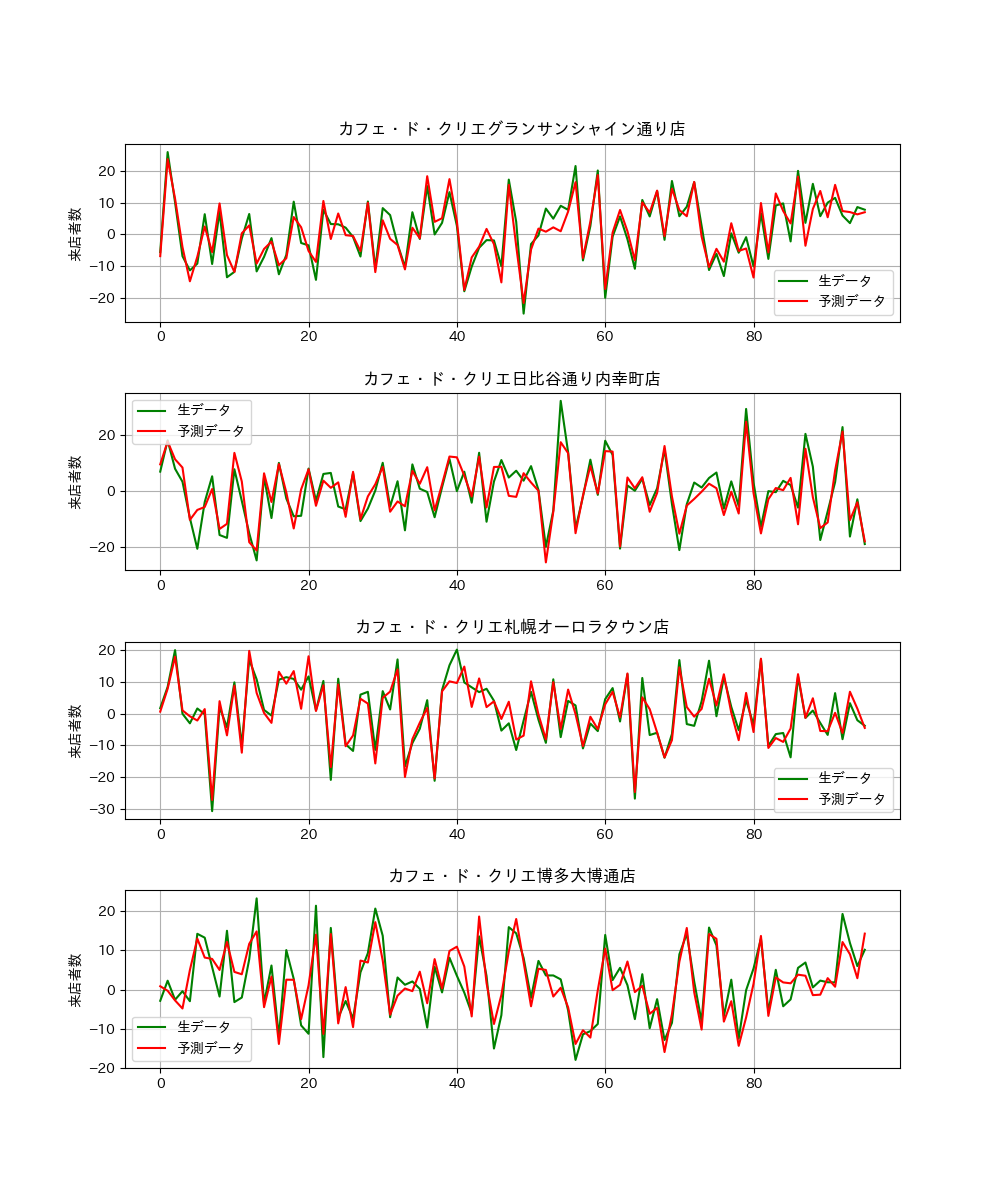

In [10]:
x_test = pd_data.values.tolist()
model  = Vector_Auto_Regressive(pd_data)

lag = 4
model.fit(lags=lag)

num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data = test_data + x_test[idx - idx2 - 1]
	tmp = model.predict([test_data])
	mean.append(tmp[0])

x_test, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_test[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_test[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_test[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_test[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()


model.stat_inf()

In [7]:
print(model.stat_inf())
print(model.log_likelihood())
print(model.model_reliability(ic="aic"))
print(model.model_reliability(ic="bic"))
print(model.model_reliability(ic="hqic"))

{'mean': array([[-1.587937  ],
       [-4.84336466],
       [ 0.29693228],
       [-1.21726724],
       [-1.8715304 ],
       [ 1.30631531],
       [-5.76232222],
       [ 1.96953329],
       [11.04034675],
       [ 0.5419252 ],
       [ 6.35302674],
       [ 3.15628957],
       [ 4.76658454],
       [-0.34811525],
       [-4.32070513],
       [ 4.68391589],
       [-2.48287839],
       [ 3.355944  ],
       [-4.25180804],
       [-7.15154522]])}


LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [8]:
lag = model.select_order(maxlag=20, ic="hqic", isVisible=True)

AR model | hqic
AR(1) | 97.08712919714576
AR(2) | 100.23080872307463
AR(3) | 55.53031187822348
AR(4) | 123.33673679199572
AR(5) | 234.95379218099583
AR(6) | 402.65962734086577
AR(7) | 271.238364743166
AR(8) | 364.15648730515477
AR(9) | 288.92933323696815
AR(10) | 368.1684359022775
AR(11) | 354.35799943242375
AR(12) | 374.98788965285513
AR(13) | 423.7781689746424
AR(14) | 409.304127537314
AR(15) | 500.5231162584546
AR(16) | 454.45232189482965
AR(17) | 451.5753884182021
AR(18) | 478.6801917500844
AR(19) | 541.7946608264496
AR(20) | 541.0312147564151
selected orders | 3


{'mean': array([[-1.587937  ],
        [-4.84336466],
        [ 0.29693228],
        [-1.21726724],
        [-1.8715304 ],
        [ 1.30631531],
        [-5.76232222],
        [ 1.96953329],
        [11.04034675],
        [ 0.5419252 ],
        [ 6.35302674],
        [ 3.15628957],
        [ 4.76658454],
        [-0.34811525],
        [-4.32070513],
        [ 4.68391589],
        [-2.48287839],
        [ 3.355944  ],
        [-4.25180804],
        [-7.15154522]])}

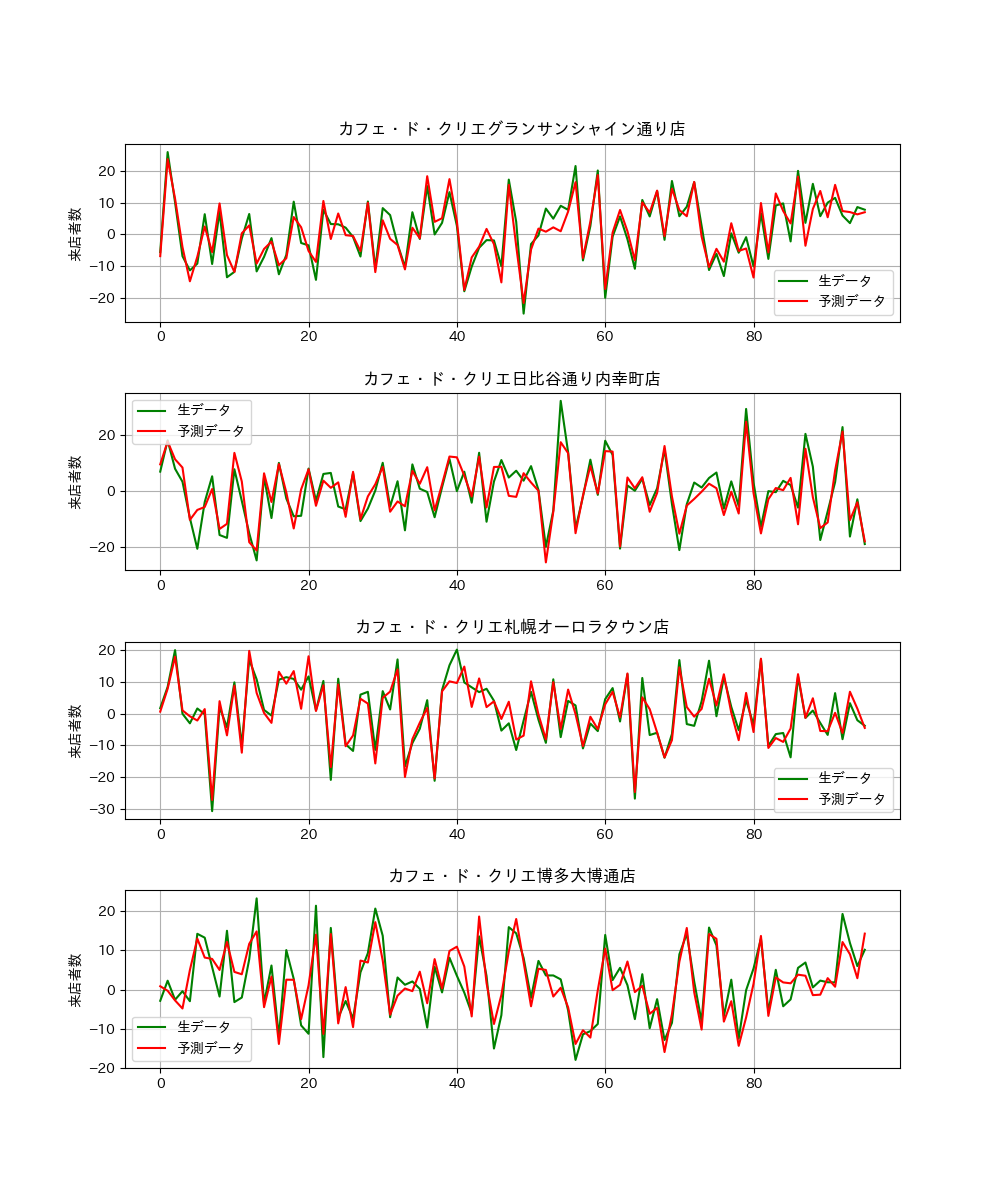

In [14]:
x_test = pd_data.values.tolist()
num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data = test_data + x_test[idx - idx2 - 1]
	tmp = model.predict([test_data])
	mean.append(tmp[0])

x_plot, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_plot[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_plot[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_plot[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_plot[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()


model.stat_inf()

In [15]:
x_test = pd_data.values.tolist()
num = len(x_test)
mean = []
test_data = []
for idx in range(0, lag):
	test_data = test_data + x_test[lag - idx - 1]
for idx in range(lag, num):
	tmp = model.predict([test_data])
	mean.append(tmp[0])
	test_data = [*tmp[0], *test_data[0:-4]]

x_plot, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_plot[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_plot[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_plot[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_plot[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

model.stat_inf()

ValueError: shapes (1,96) and (80,20) not aligned: 96 (dim 1) != 80 (dim 0)

In [15]:
print("グレンジャー因果性テスト(p値 = 0.05)")
print("")

t = model.test_causality(causing=0, caused=1)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=0, caused=2)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=0, caused=3)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=0)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=2)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=3)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=0)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=1)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=3)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=0)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=1)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=2)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

グレンジャー因果性テスト(p値 = 0.05)

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 4.635668874817753    p値: 0.3267623452673172
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 3.806783960336983    p値: 0.4327858360303505
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ博多大博通店
F検定量: 4.942986381802937    p値: 0.2931976350140899
グレンジャー因果性無し

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 23.130449004350112    p値: 0.00011924963797197117
グレンジャー因果性有り

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 23.79208192653197    p値: 8.791671596746922e-05
グレンジャー因果性有り

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ博多大博通店
F検定量: 27.3382277031235    p値: 1.698177807511382e-05
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 32.92138882516249    p値: 1.2395748607921363e-06
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 22.141770062529794    p値: 0.00018780832295899267
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ博多大博通店
F検定量: 29.800552794818884    p値: 5.373990020069395e-06
グレンジャー因果性有り

カフェ・ド・クリエ博多大博通

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


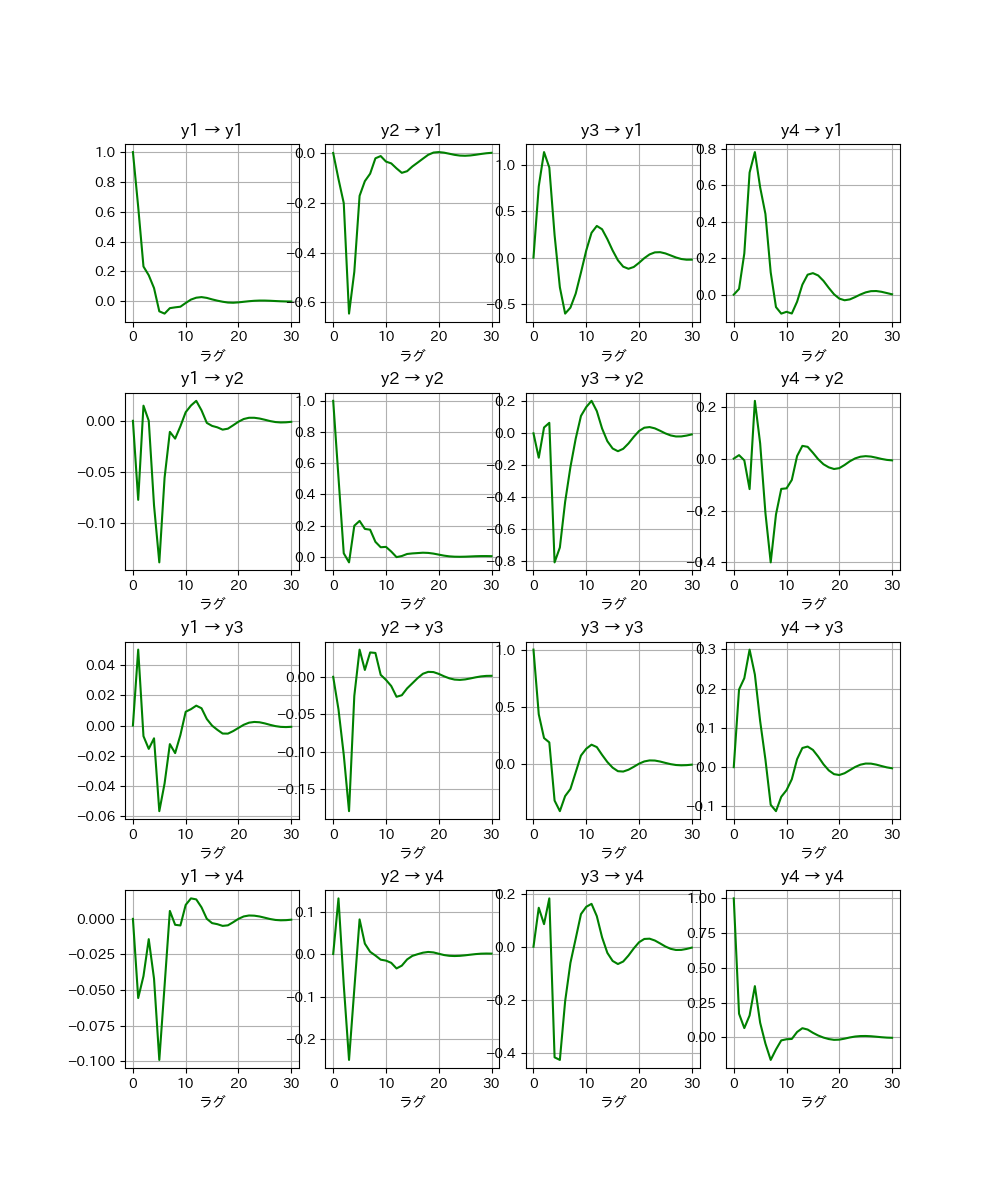

In [16]:
irf = model.irf(priod=30, orth=False)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,4,1)
plt.plot(irf[:, 0, 0], "-", color="green", label="生データ")
plt.title("y1 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,2)
plt.plot(irf[:, 0, 1], "-", color="green", label="生データ")
plt.title("y2 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,3)
plt.plot(irf[:, 0, 2], "-", color="green", label="生データ")
plt.title("y3 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,4)
plt.plot(irf[:, 0, 3], "-", color="green", label="生データ")
plt.title("y4 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,5)
plt.plot(irf[:, 1, 0], "-", color="green", label="生データ")
plt.title("y1 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,6)
plt.plot(irf[:, 1, 1], "-", color="green", label="生データ")
plt.title("y2 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,7)
plt.plot(irf[:, 1, 2], "-", color="green", label="生データ")
plt.title("y3 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,8)
plt.plot(irf[:, 1, 3], "-", color="green", label="生データ")
plt.title("y4 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,9)
plt.plot(irf[:, 2, 0], "-", color="green", label="生データ")
plt.title("y1 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,10)
plt.plot(irf[:, 2, 1], "-", color="green", label="生データ")
plt.title("y2 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,11)
plt.plot(irf[:, 2, 2], "-", color="green", label="生データ")
plt.title("y3 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,12)
plt.plot(irf[:, 2, 3], "-", color="green", label="生データ")
plt.title("y4 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,13)
plt.plot(irf[:, 3, 0], "-", color="green", label="生データ")
plt.title("y1 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,14)
plt.plot(irf[:, 3, 1], "-", color="green", label="生データ")
plt.title("y2 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,15)
plt.plot(irf[:, 3, 2], "-", color="green", label="生データ")
plt.title("y3 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,16)
plt.plot(irf[:, 3, 3], "-", color="green", label="生データ")
plt.title("y4 → y4")
plt.xlabel("ラグ")
plt.grid(True)




In [17]:
irf

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 6.32764395e-01, -1.04481099e-01,  7.71505688e-01,
          3.15167005e-02],
        [-7.71060499e-02,  5.08694029e-01, -1.52836581e-01,
          1.34059388e-02],
        [ 5.03147862e-02, -4.34673791e-02,  4.34027011e-01,
          1.97367545e-01],
        [-5.55490961e-02,  1.30926492e-01,  1.47192103e-01,
          1.69968801e-01]],

       [[ 2.32834651e-01, -2.01358954e-01,  1.14224541e+00,
          2.25823470e-01],
        [ 1.47865207e-02,  2.16699978e-02,  3.64247601e-02,
         -6.73941235e-03],
        [-7.03744712e-03, -1.04161123e-01,  2.25783616e-01,
          2.26350200e-01],
        [-4.01823924e-02, -7.27479069e-

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


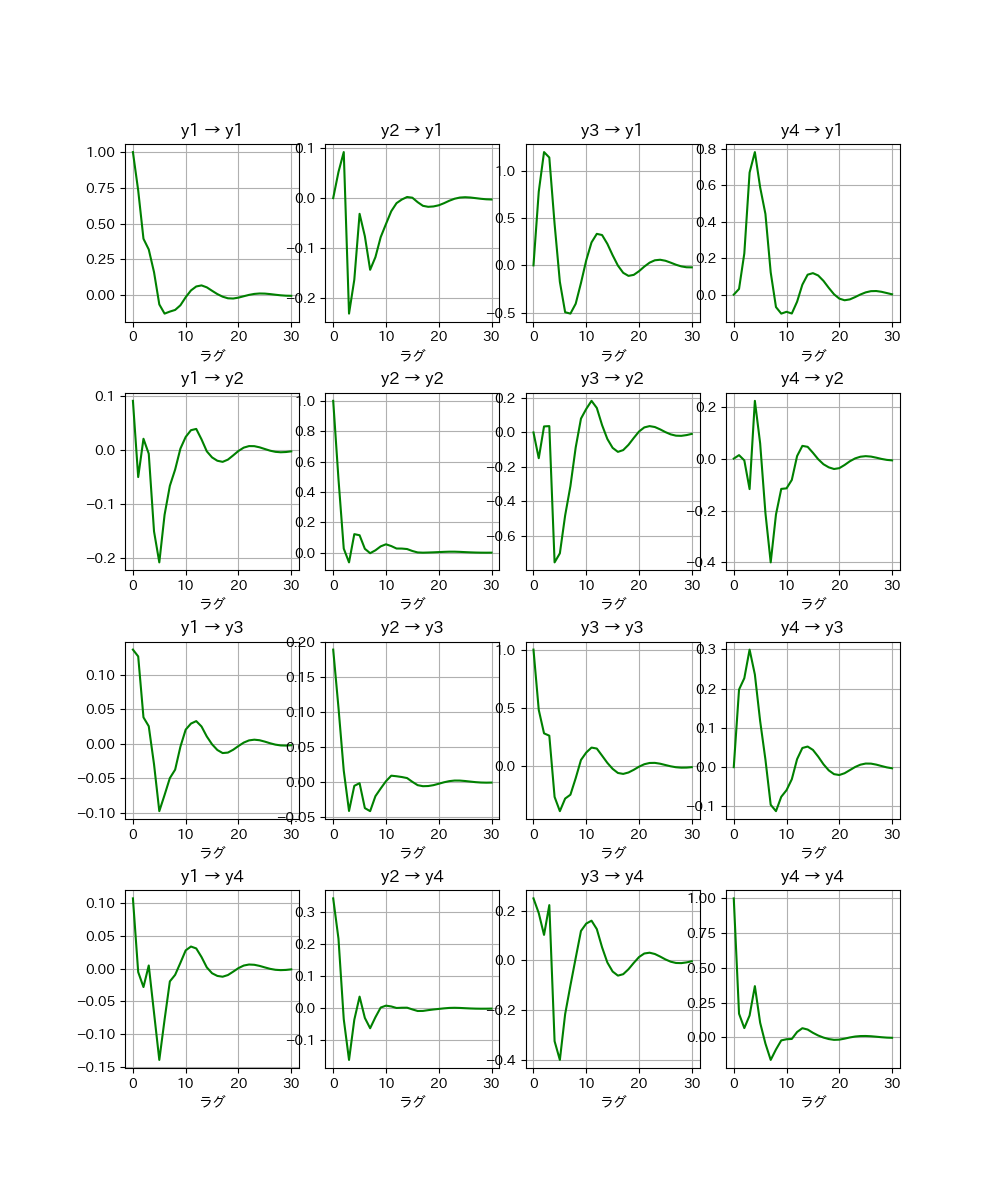

In [18]:
irf = model.irf(priod=30, orth=True)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,4,1)
plt.plot(irf[:, 0, 0], "-", color="green", label="生データ")
plt.title("y1 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,2)
plt.plot(irf[:, 0, 1], "-", color="green", label="生データ")
plt.title("y2 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,3)
plt.plot(irf[:, 0, 2], "-", color="green", label="生データ")
plt.title("y3 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,4)
plt.plot(irf[:, 0, 3], "-", color="green", label="生データ")
plt.title("y4 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,5)
plt.plot(irf[:, 1, 0], "-", color="green", label="生データ")
plt.title("y1 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,6)
plt.plot(irf[:, 1, 1], "-", color="green", label="生データ")
plt.title("y2 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,7)
plt.plot(irf[:, 1, 2], "-", color="green", label="生データ")
plt.title("y3 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,8)
plt.plot(irf[:, 1, 3], "-", color="green", label="生データ")
plt.title("y4 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,9)
plt.plot(irf[:, 2, 0], "-", color="green", label="生データ")
plt.title("y1 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,10)
plt.plot(irf[:, 2, 1], "-", color="green", label="生データ")
plt.title("y2 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,11)
plt.plot(irf[:, 2, 2], "-", color="green", label="生データ")
plt.title("y3 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,12)
plt.plot(irf[:, 2, 3], "-", color="green", label="生データ")
plt.title("y4 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,13)
plt.plot(irf[:, 3, 0], "-", color="green", label="生データ")
plt.title("y1 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,14)
plt.plot(irf[:, 3, 1], "-", color="green", label="生データ")
plt.title("y2 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,15)
plt.plot(irf[:, 3, 2], "-", color="green", label="生データ")
plt.title("y3 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,16)
plt.plot(irf[:, 3, 3], "-", color="green", label="生データ")
plt.title("y4 → y4")
plt.xlabel("ラグ")
plt.grid(True)
plt.show()

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


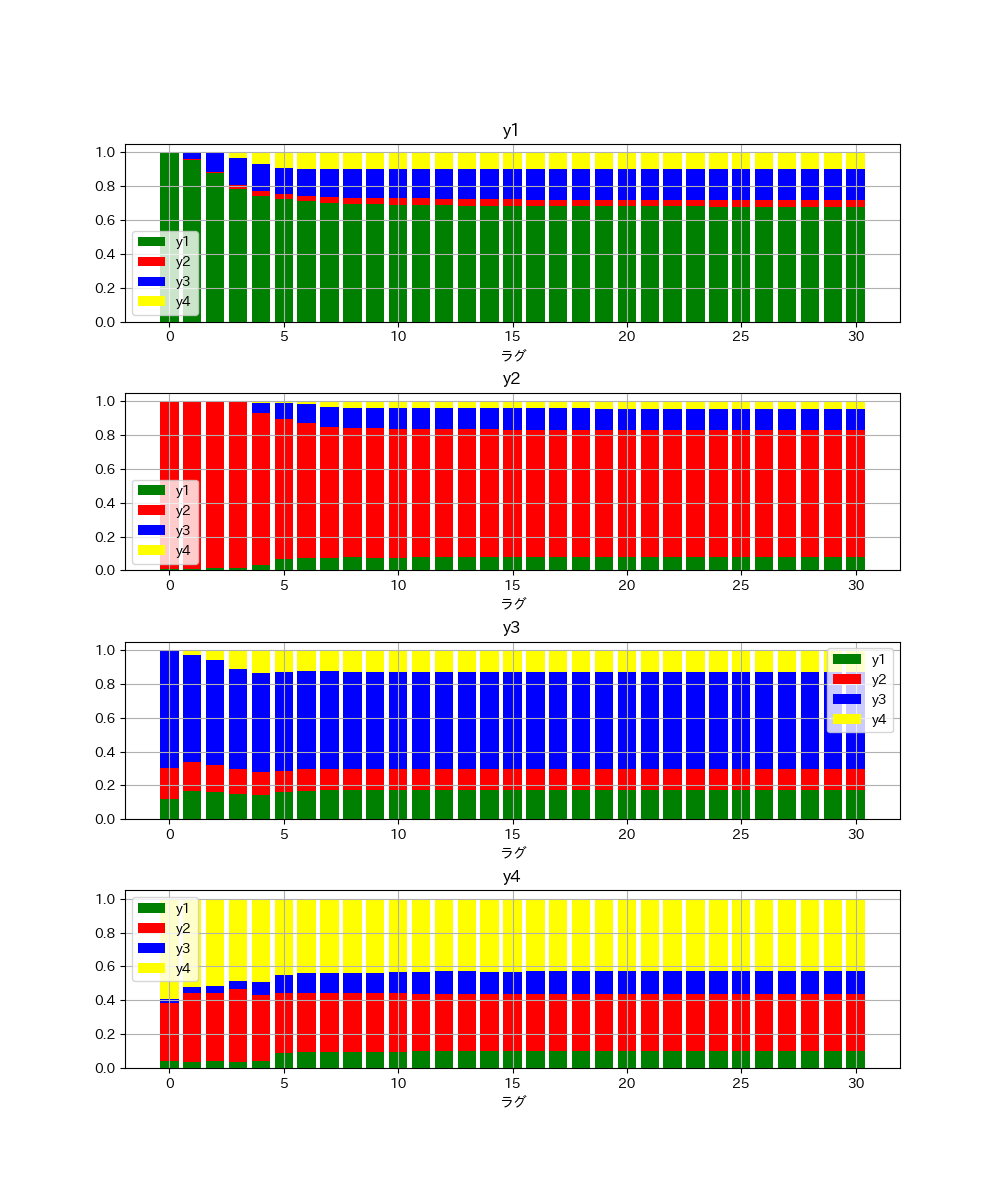

In [19]:
priods = 30
fevd = model.fevd(priod=priods)
priods = len(fevd)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
ticks  = np.arange(priods)
lower  = np.zeros(priods)
height = fevd[:, 0, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 0, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 0, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 0, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y1")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
lower  = np.zeros(priods)
height = fevd[:, 1, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 1, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 1, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 1, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y2")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
lower  = np.zeros(priods)
height = fevd[:, 2, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 2, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 2, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 2, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y3")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
lower  = np.zeros(priods)
height = fevd[:, 3, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 3, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 3, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 3, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y4")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()


In [20]:
irf = model.irf(priod=1, orth=True)
print(irf.round(4))

[[[ 1.      0.      0.      0.    ]
  [ 0.0914  1.      0.      0.    ]
  [ 0.1364  0.1893  1.      0.    ]
  [ 0.1064  0.3426  0.2488  1.    ]]

 [[ 0.7318  0.0524  0.7793  0.0315]
  [-0.05    0.4843 -0.1495  0.0134]
  [ 0.1265  0.1063  0.4831  0.1974]
  [-0.0054  0.217   0.1895  0.17  ]]]
